## 1. Imports

In [2]:
import os
import json
import torch
import numpy as np
from pathlib import Path
from datasets import Dataset, DatasetDict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    Trainer,
    TrainingArguments,
    DataCollatorForTokenClassification,
)

## 2. DATA LOADING

In [3]:
# Deine lokalen Windows-Pfade
TRAIN_DIR = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\train")
DEV_DIR   = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\dev")
TEST_DIR  = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\test")

assert TRAIN_DIR.exists(), f"Train-Ordner nicht gefunden: {TRAIN_DIR}"
assert DEV_DIR.exists(),   f"Dev-Ordner nicht gefunden:   {DEV_DIR}"
assert TEST_DIR.exists(),  f"Test-Ordner nicht gefunden:  {TEST_DIR}"
def load_docie_docs(folder: Path, recursive: bool = False):
    """Load DocIE documents from JSON files."""
    docs = []
    pattern = "**/*.json" if recursive else "*.json"
    for file in folder.glob(pattern):
        data = json.loads(file.read_text(encoding="utf-8"))
        if isinstance(data, list):
            docs.extend(data)
        else:
            docs.append(data)
    return docs

# Load data
train_docs = load_docie_docs(TRAIN_DIR)
dev_docs = load_docie_docs(DEV_DIR)
test_docs = load_docie_docs(TEST_DIR, recursive=True)

print(f"Dataset sizes - Train: {len(train_docs)}, Dev: {len(dev_docs)}, Test: {len(test_docs)}")

Dataset sizes - Train: 51, Dev: 23, Test: 248


## 3. LABEL MAPPING SETUP

In [4]:
# Extract entity types from training data
entity_types = set()
for doc in train_docs:
    if "entity_label_set" in doc:
        entity_types.update(doc["entity_label_set"])
    elif "NER_label_set" in doc:
        entity_types.update(doc["NER_label_set"])

entity_types = sorted(list(entity_types))

# Create BIO labels
ner_labels = ["O"]
for entity_type in entity_types:
    ner_labels.extend([f"B-{entity_type}", f"I-{entity_type}"])

# Create label mappings
label2id = {label: idx for idx, label in enumerate(ner_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Number of NER labels: {len(ner_labels)}")
print(f"Entity types: {entity_types}")

Number of NER labels: 39
Entity types: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MISC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


## 4. TOKENIZATION AND DATASET PREPARATION

In [5]:
# Initialize tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Tokenization parameters
max_length = 512
stride = 128

def tokenize_and_align_labels(examples):
    """Tokenize text and align NER labels with subword tokens."""
    all_input_ids = []
    all_attention_mask = []
    all_labels = []
    
    for doc, entities in zip(examples["doc"], examples["entities"]):
        # Tokenize with return_offsets_mapping for alignment
        tokenized = tokenizer(
            doc,
            return_offsets_mapping=True,
            truncation=True,
            max_length=max_length,
            stride=stride,
            return_overflowing_tokens=True,
        )
        
        # Process each chunk
        for i in range(len(tokenized["input_ids"])):
            input_ids = tokenized["input_ids"][i]
            attention_mask = tokenized["attention_mask"][i]
            offsets = tokenized["offset_mapping"][i]
            
            # Initialize labels as "O"
            chunk_labels = ["O"] * len(input_ids)
            
            # Align entity labels
            for entity in entities:
                entity_type = entity["type"]
                for mention in entity.get("mentions", []):
                    start_char = doc.find(mention)
                    if start_char == -1:
                        continue
                    end_char = start_char + len(mention)
                    
                    # Find tokens that overlap with entity
                    for idx, (token_start, token_end) in enumerate(offsets):
                        if token_start >= start_char and token_end <= end_char:
                            if token_start == start_char:
                                chunk_labels[idx] = f"B-{entity_type}"
                            else:
                                chunk_labels[idx] = f"I-{entity_type}"
            
            # Convert labels to IDs
            label_ids = [label2id.get(label, label2id["O"]) for label in chunk_labels]
            
            # Special tokens get -100 (ignored in loss)
            label_ids = [
                -100 if offsets[i] == (0, 0) else label_ids[i] 
                for i in range(len(label_ids))
            ]
            
            all_input_ids.append(input_ids)
            all_attention_mask.append(attention_mask)
            all_labels.append(label_ids)
    
    return {
        "input_ids": all_input_ids,
        "attention_mask": all_attention_mask,
        "labels": all_labels,
    }

# Create HuggingFace datasets
hf_train = Dataset.from_list(train_docs)
hf_dev = Dataset.from_list(dev_docs)
hf_test = Dataset.from_list(test_docs)

# Apply tokenization
columns_to_remove = ["domain", "title", "doc", "entities", "triples", 
                     "label_set", "entity_label_set", "document", 
                     "RE_label_set", "NER_label_set", "id"]

tokenized_train = hf_train.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=[col for col in columns_to_remove if col in hf_train.column_names]
)

tokenized_dev = hf_dev.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=[col for col in columns_to_remove if col in hf_dev.column_names]
)

print(f"Tokenized dataset sizes - Train: {len(tokenized_train)}, Dev: {len(tokenized_dev)}")

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Tokenized dataset sizes - Train: 166, Dev: 74


## 5. METRICS AND DATA COLLATOR

In [6]:
# Data collator for padding
data_collator = DataCollatorForTokenClassification(tokenizer)

def compute_metrics(eval_pred):
    """Compute precision, recall, and F1 for NER."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    
    # Flatten and remove special tokens (-100)
    predictions = predictions.flatten()
    labels = labels.flatten()
    mask = labels != -100
    
    predictions = predictions[mask]
    labels = labels[mask]
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='micro', zero_division=0
    )
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

## 6. BASELINE MODEL TRAINING

In [7]:
print("\n" + "="*50)
print("TRAINING BASELINE MODEL")
print("="*50)

# Initialize model
baseline_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(ner_labels),
    id2label=id2label,
    label2id=label2id,
)

# Training arguments
baseline_args = TrainingArguments(
    output_dir="outputs/bert-ner-baseline",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# Create trainer
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train
baseline_trainer.train()

# Evaluate
baseline_results = baseline_trainer.evaluate()
print(f"\nBaseline Results:")
print(f"F1: {baseline_results['eval_f1']:.4f}")
print(f"Precision: {baseline_results['eval_precision']:.4f}")
print(f"Recall: {baseline_results['eval_recall']:.4f}")



TRAINING BASELINE MODEL


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_34348\1040768143.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.649539,0.885307,0.885307,0.885307,0.885307
2,No log,0.612819,0.885307,0.885307,0.885307,0.885307
3,No log,0.583608,0.885307,0.885307,0.885307,0.885307



Baseline Results:
F1: 0.8853
Precision: 0.8853
Recall: 0.8853


## 7. FINE-TUNING WITH BEST HYPERPARAMETERS

In [8]:
# Based on your hyperparameter tuning results:
best_hyperparams = {
    "full_ft": {
        "learning_rate": 4.358610256985791e-05,
        "batch_size": 16,
        "method_name": "Full Fine-Tuning"
    },
    "lora": {
        "learning_rate": 2.220149951658828e-05,
        "r": 16,
        "alpha": 16,
        "dropout": 0.015844640852335577,
        "batch_size": 8,
        "method_name": "LoRA"
    },
    "partial_freeze": {
        "freeze_pct": 0.5,
        "learning_rate": 3.2302001133689886e-05,
        "batch_size": 16,
        "method_name": "Partial Freeze"
    }
}

results_summary = {
    "baseline": baseline_results
}

## 7.1 FULL FINE-TUNING


In [12]:
print("\n" + "="*50)
print("FULL FINE-TUNING WITH BEST PARAMETERS")
print("="*50)

# Create fresh model
ft_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(ner_labels),
    id2label=id2label,
    label2id=label2id,
)

# Training arguments with best hyperparameters
ft_args = TrainingArguments(
    output_dir="outputs/bert-ner-full-ft-final",
    max_steps=100,  # Fixed budget for fair comparison
    per_device_train_batch_size=best_hyperparams["full_ft"]["batch_size"],
    per_device_eval_batch_size=32,
    learning_rate=best_hyperparams["full_ft"]["learning_rate"],
    evaluation_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    logging_steps=20,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# Train
ft_trainer = Trainer(
    model=ft_model,
    args=ft_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

ft_trainer.train()
ft_results = ft_trainer.evaluate()
results_summary["full_ft"] = ft_results

print(f"\nFull Fine-Tuning Results:")
print(f"F1: {ft_results['eval_f1']:.4f}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



FULL FINE-TUNING WITH BEST PARAMETERS


C:\Users\nmilo\AppData\Local\Temp\ipykernel_34348\42561499.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ft_trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.314200,0.582728,0.885307,0.885307,0.885307,0.885307
40,0.744800,0.489795,0.885277,0.885277,0.885277,0.885277
60,0.666400,0.459513,0.889698,0.889698,0.889698,0.889698
80,0.605900,0.437836,0.892026,0.892026,0.892026,0.892026
100,0.524900,0.432223,0.891554,0.891554,0.891554,0.891554



Full Fine-Tuning Results:
F1: 0.8916


## 7.2 LoRA FINE-TUNING

In [13]:
print("\n" + "="*50)
print("LoRA FINE-TUNING WITH BEST PARAMETERS")
print("="*50)

from peft import LoraConfig, get_peft_model, TaskType

# Create fresh model
base_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(ner_labels),
    id2label=id2label,
    label2id=label2id,
)

# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    inference_mode=False,
    r=best_hyperparams["lora"]["r"],
    lora_alpha=best_hyperparams["lora"]["alpha"],
    lora_dropout=best_hyperparams["lora"]["dropout"],
    target_modules=["query", "value"],  # BERT-specific
)

# Apply LoRA
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

# Training arguments
lora_args = TrainingArguments(
    output_dir="outputs/bert-ner-lora-final",
    max_steps=100,
    per_device_train_batch_size=best_hyperparams["lora"]["batch_size"],
    per_device_eval_batch_size=16,
    learning_rate=best_hyperparams["lora"]["learning_rate"],
    evaluation_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    logging_steps=20,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# Train
lora_trainer = Trainer(
    model=lora_model,
    args=lora_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

lora_trainer.train()
lora_results = lora_trainer.evaluate()
results_summary["lora"] = lora_results

print(f"\nLoRA Results:")
print(f"F1: {lora_results['eval_f1']:.4f}")



LoRA FINE-TUNING WITH BEST PARAMETERS


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_34348\2177920545.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will 

trainable params: 619,815 || all params: 109,541,454 || trainable%: 0.5658


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.837200,3.750606,0.006071,0.006071,0.006071,0.006071
40,3.729700,3.643124,0.014381,0.014381,0.014381,0.014381
60,3.642900,3.558876,0.031237,0.031237,0.031237,0.031237
80,3.574600,3.504576,0.048447,0.048447,0.048447,0.048447
100,3.544400,3.485232,0.056050,0.056050,0.056050,0.056050



LoRA Results:
F1: 0.0560


## 7.3 PARTIAL FREEZE FINE-TUNING

In [14]:
print("\n" + "="*50)
print("PARTIAL FREEZE FINE-TUNING WITH BEST PARAMETERS")
print("="*50)

# Create fresh model
freeze_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(ner_labels),
    id2label=id2label,
    label2id=label2id,
)

# Freeze bottom 50% of layers
freeze_pct = best_hyperparams["partial_freeze"]["freeze_pct"]
num_layers = len([n for n, _ in freeze_model.named_parameters() if "encoder.layer" in n]) // 2
freeze_until = int(num_layers * freeze_pct)

for name, param in freeze_model.named_parameters():
    if "encoder.layer" in name:
        layer_num = int(name.split(".")[3])
        if layer_num < freeze_until:
            param.requires_grad = False

# Count trainable parameters
trainable_params = sum(p.numel() for p in freeze_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in freeze_model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

# Training arguments
freeze_args = TrainingArguments(
    output_dir="outputs/bert-ner-freeze-final",
    max_steps=100,
    per_device_train_batch_size=best_hyperparams["partial_freeze"]["batch_size"],
    per_device_eval_batch_size=32,
    learning_rate=best_hyperparams["partial_freeze"]["learning_rate"],
    evaluation_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    logging_steps=20,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# Train
freeze_trainer = Trainer(
    model=freeze_model,
    args=freeze_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

freeze_trainer.train()
freeze_results = freeze_trainer.evaluate()
results_summary["partial_freeze"] = freeze_results

print(f"\nPartial Freeze Results:")
print(f"F1: {freeze_results['eval_f1']:.4f}")



PARTIAL FREEZE FINE-TUNING WITH BEST PARAMETERS


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_34348\160557065.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  freeze_trainer = Trainer(


Trainable parameters: 23,867,175 / 108,921,639 (21.91%)


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.651700,3.545870,0.057612,0.057612,0.057612,0.057612
40,3.487800,3.393096,0.159840,0.159840,0.159840,0.159840
60,3.365600,3.281527,0.281340,0.281340,0.281340,0.281340
80,3.284500,3.212695,0.364148,0.364148,0.364148,0.364148
100,3.230400,3.188612,0.394206,0.394206,0.394206,0.394206



Partial Freeze Results:
F1: 0.3942


## 8. RESULTS COMPARISON

In [15]:

print("\n" + "="*50)
print("RESULTS COMPARISON")
print("="*50)

# Create comparison table
import pandas as pd

comparison_data = []
for method, results in results_summary.items():
    comparison_data.append({
        "Method": method.replace("_", " ").title(),
        "F1": results.get("eval_f1", 0) * 100,
        "Precision": results.get("eval_precision", 0) * 100,
        "Recall": results.get("eval_recall", 0) * 100,
        "Accuracy": results.get("eval_accuracy", 0) * 100,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(2)
print(comparison_df.to_string(index=False))


RESULTS COMPARISON
        Method    F1  Precision  Recall  Accuracy
      Baseline 88.53      88.53   88.53     88.53
       Full Ft 89.16      89.16   89.16     89.16
          Lora  5.60       5.60    5.60      5.60
Partial Freeze 39.42      39.42   39.42     39.42


## 9. VISUALIZATION

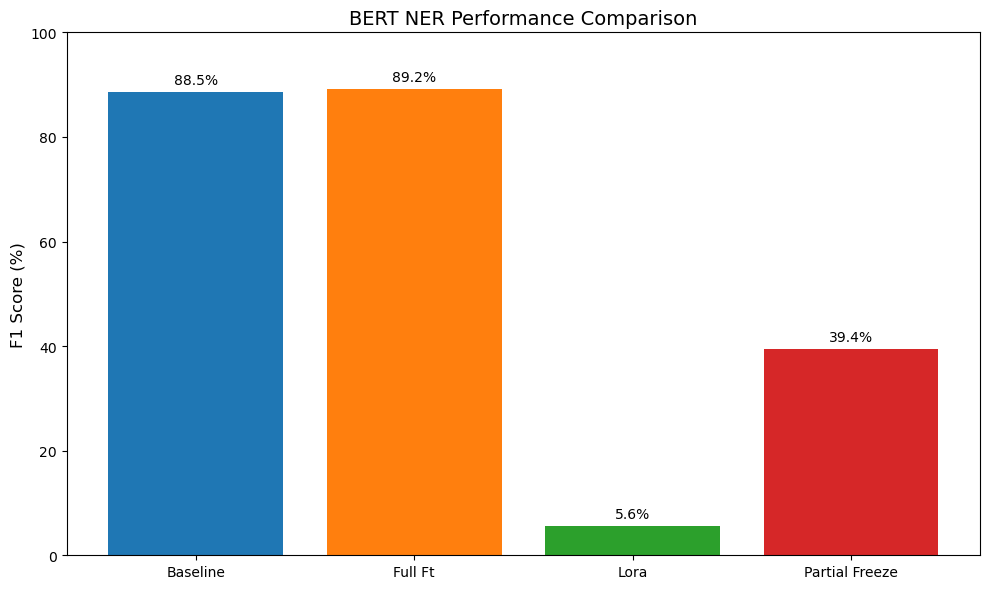

In [16]:
# Bar plot for F1 scores
plt.figure(figsize=(10, 6))
methods = comparison_df["Method"].tolist()
f1_scores = comparison_df["F1"].tolist()

bars = plt.bar(methods, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylabel('F1 Score (%)', fontsize=12)
plt.title('BERT NER Performance Comparison', fontsize=14)
plt.ylim(0, 100)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{score:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('outputs/bert_ner_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. TEST SET EVALUATION (FINAL MODEL)

In [17]:
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)

# Use the best performing model (full fine-tuning based on your results)
# Note: For test set, we need to handle the different structure
test_examples = []
for doc in test_docs:
    # Test docs have different structure
    text = doc.get("document", doc.get("doc", ""))
    if text:
        test_examples.append({
            "doc": text,
            "entities": [],  # No labels in test set
            "id": doc.get("id", "")
        })

hf_test_for_inference = Dataset.from_list(test_examples)

# Tokenize test set
tokenized_test = hf_test_for_inference.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=hf_test_for_inference.column_names
)

# Get predictions from best model
test_predictions = ft_trainer.predict(tokenized_test)
predictions = np.argmax(test_predictions.predictions, axis=-1)

# Convert predictions back to labels
predicted_labels = []
for pred_seq in predictions:
    labels = [id2label[p] for p in pred_seq if p != -100]
    predicted_labels.append(labels)

print(f"Generated predictions for {len(predicted_labels)} test examples")


FINAL TEST SET EVALUATION


Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Generated predictions for 731 test examples


## 11. SAVE RESULTS

In [18]:
# Save comparison table
comparison_df.to_csv("outputs/bert_ner_results.csv", index=False)

# Save best model
ft_trainer.save_model("outputs/bert-ner-best-model")
tokenizer.save_pretrained("outputs/bert-ner-best-model")

# Save predictions
import json
with open("outputs/bert_ner_test_predictions.json", "w") as f:
    json.dump({
        "predictions": predicted_labels[:10],  # Sample
        "model": "bert-base-uncased",
        "task": "NER",
        "best_f1": float(ft_results['eval_f1'])
    }, f, indent=2)

print("\n✅ All results saved to outputs/")
print("📊 Visualization saved as bert_ner_comparison.png")
print("💾 Best model saved to outputs/bert-ner-best-model/")


✅ All results saved to outputs/
📊 Visualization saved as bert_ner_comparison.png
💾 Best model saved to outputs/bert-ner-best-model/
